## Spotify Query

In this notebook we perform some query on our property graph about Spotify. In particular the queries will be divided into three parts:
1. ***Example queries***: we perform two example queries where we show how it is possibile to use the new added information such as *record label* and *instruments*.
1. ***Italian tracks and Italian artists from 2017 to 2020:*** we perfom some queries about italian tracks and artists present in the TOP 100 Italy.
1. ***Italian tracks abroad:*** we want to discover if italian tracks are listened also outside Italy.

In [2]:
# Import required libraries
import pandas as pd
import calendar
import numpy as np
import matplotlib.pyplot as plt
import os

### Connection to Neo4j

In [3]:
# Neo4J params class
class Neo4jParams:
  def __init__(self, user, psw,dbname,db_psw,uri):
    self.user = user
    self.psw = psw
    self.dbname = dbname
    self.dbpsw = dbpsw
    self.uri = uri

In [4]:
#DB parameters
user = "neo4j"
psw = "neo4j"
dbname = "SpotifyDB"
dbpsw = "SpotifyDB"
uri = "bolt://localhost:7687"

params = Neo4jParams(user,psw,dbname,dbpsw,uri)

In [5]:
from neo4j import GraphDatabase

# Test class
class Driver:

    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self.driver.close()

    def print_greeting(self, message):
        with self.driver.session() as session:
            greeting = session.write_transaction(self._create_and_return_greeting, message)
            print(greeting)

    @staticmethod
    def _create_and_return_greeting(tx, message):
        result = tx.run("CREATE (a:Greeting) "
                        "SET a.message = $message "
                        "RETURN a.message + ', from node ' + id(a)", message=message)
        return result.single()[0]


if __name__ == "__main__":
    greeter = Driver("bolt://localhost:7687", "neo4j", "SpotifyDB")
    greeter.print_greeting("hello, world")
    greeter.close()

hello, world, from node 44386


## Plot utilities

In [6]:
TITLE_PAD = 30
TITLE_DIM = 30
XY_LABEL_PAD = 23
XY_LABEL_DIM = 21
XY_TICKS_DIM = 18
GRID_ALPHA = 0.2
FILL_ALPHA = 0.05
BAR_WIDTH = 0.95
LEGEND_LOC = "upper left"
LEGEND_LABEL_DIM = 15
COLOR_SCHEME = ["#1DB954", "#22577A", "#A03C78", "#C67ACE"]

FIG_SIZE = (18, 8)
FIG_BG_COLOR = None # "w"
FIG_DPI = 500
FIG_BBOX = "tight"
FIG_PAD = .3
FIG_FORMATS = ["png", "pdf"]


In [7]:
def plotResults(title=None, x=[], yArr=[],
                xLabel=None, xTicks=None, xTicksPosition=None, xTicksRotation=0,
                yLim=None, yLabel=None, yTicks=None, yTicksPosition=None, yTicksRotation=0,
                legend=None, legendLocation=LEGEND_LOC,
                style="line", showGrid=False, gridAxis="both", fillPlot=False,
                figSize=FIG_SIZE, saveTitle=None):

    plt.figure(figsize=figSize, facecolor=FIG_BG_COLOR)

    maxY = None
    minY = None

    numPlots = len(yArr)
    for i, y in zip(range(numPlots), yArr):
        label = None
        try:
            label = legend[i]
        except:
            pass

        yNum = [float(yVal) for yVal in y]
        maxY = np.max(
            [np.max(yNum), maxY]
        ) if not maxY is None else np.max(yNum)
        minY = np.min(
            [np.min(yNum), minY]
        ) if not minY is None else np.min(yNum)

        if style == "line":
            plt.plot(x, yNum, label=label, color=COLOR_SCHEME[i])

            if fillPlot:
                plt.fill_between(x, yNum, alpha=FILL_ALPHA,
                                 facecolor=COLOR_SCHEME[i])

        elif style == "bar":
            barWidth = BAR_WIDTH / numPlots
            xOffset = -BAR_WIDTH / 2 + barWidth / 2 + barWidth * i
            plt.bar(x + xOffset, yNum, width=barWidth,
                    label=label, align="center", color=COLOR_SCHEME[i])

        elif style == "polar":
            x = np.linspace(0, 2 * np.pi, len(yNum) + 1, endpoint=True)
            yNum.append(yNum[0])
            plt.polar(x, yNum, label=label, color=COLOR_SCHEME[i])

            if fillPlot:
                plt.fill(x, yNum, alpha=FILL_ALPHA,
                         facecolor=COLOR_SCHEME[i])

        elif style == "boxplot":
            lineWidth = 1.5

            if fillPlot:
                plt.boxplot(yNum,
                            positions=[i],
                            notch=True,
                            widths=[1 / numPlots],
                            patch_artist=True,
                            showcaps=False,
                            showfliers=False,
                            showmeans=False,
                            boxprops=dict(
                                facecolor=COLOR_SCHEME[i],
                                alpha=FILL_ALPHA,
                            ),
                            )

            plt.boxplot(yNum,
                        positions=[i],
                        notch=True,
                        widths=[1 / numPlots],
                        boxprops=dict(
                            color=COLOR_SCHEME[i],
                            linewidth=lineWidth,
                        ),
                        capprops=dict(
                            color=COLOR_SCHEME[i],
                            linewidth=lineWidth,
                        ),
                        whiskerprops=dict(
                            color=COLOR_SCHEME[i],
                            linewidth=lineWidth,
                        ),
                        flierprops=dict(
                            color=COLOR_SCHEME[i],
                            markeredgecolor=COLOR_SCHEME[i],
                            markerfacecolor=COLOR_SCHEME[i],
                        ),
                        medianprops=dict(
                            color=COLOR_SCHEME[i],
                            linewidth=lineWidth,
                        ),
                        )

    if not xLabel is None:
        plt.xlabel(xLabel, labelpad=XY_LABEL_PAD, fontsize=XY_LABEL_DIM)

    if not yLabel is None:
        plt.ylabel(yLabel, labelpad=XY_LABEL_PAD, fontsize=XY_LABEL_DIM)

    if not xTicks is None:
        if not xTicksPosition:
            xTicksPosition = x if style != "boxplot" else np.arange(
                0, numPlots)

            if style == "polar":
                xTicks.append(xTicks[0])

        plt.xticks(xTicksPosition, xTicks, fontsize=XY_TICKS_DIM,
                   rotation=xTicksRotation)
    else:
        plt.xticks(fontsize=XY_TICKS_DIM, rotation=xTicksRotation)

    if not yTicks is None and not yTicksPosition is None:
        plt.yticks(yTicksPosition, yTicks, fontsize=XY_TICKS_DIM,
                   rotation=yTicksRotation)
    elif not yTicksPosition is None:
        plt.yticks(yTicksPosition, fontsize=XY_TICKS_DIM,
                   rotation=yTicksRotation)
    else:
        plt.yticks(fontsize=XY_TICKS_DIM, rotation=yTicksRotation)

    if yLim is None:
        yPad = (maxY - minY) * 0.1
        topLim = maxY + yPad * 2
        infLim = minY - yPad if style == "bar" else minY - yPad
        infLim = 0 if style == "bar" and minY >= 0 and minY <= yPad else infLim
        infLim = minY if style == "polar" else infLim
        plt.ylim(top=topLim, bottom=infLim)
    else:
        plt.ylim(top=yLim[1], bottom=yLim[0])

    if showGrid:
        plt.grid(alpha=GRID_ALPHA, axis=gridAxis)

    if not legend is None:
        plt.legend(loc=legendLocation, fontsize=LEGEND_LABEL_DIM)

    if not saveTitle is None:
        baseDir = "plots"
        if not os.path.exists(baseDir):
            os.mkdir("plots")

        for figFormat in FIG_FORMATS:
            saveDir = baseDir + "/" + figFormat
            if not os.path.exists(saveDir):
                os.mkdir(saveDir)

            plt.savefig(saveDir + "/" + saveTitle + "." + figFormat,
                        facecolor=FIG_BG_COLOR,
                        dpi=FIG_DPI,
                        bbox_inches=FIG_BBOX,
                        pad_inches=FIG_PAD)

    if not title is None:
        plt.title(title, fontsize=TITLE_DIM, pad=TITLE_PAD)

    plt.show()

### Example Queries

##### Q1: Show artists of the same discographic house 

##### Q2: Show the most common played instrument in rock groups

### Italian Tracks and Italian Artists

#### Q3: Show techincal features of Italian Tracks through the years 2017-2020

Year: 2018
techinalFeatures: [0.17532409156527118, 0.6989853578057337, 0.6931524025572274, 0.4963640131985969, 0.13399967003505897]

Year: 2020
techinalFeatures: [0.15286473820297378, 0.7014070243482002, 0.7065494505494508, 0.505113466925233, 0.1422100840336131]

Year: 2019
techinalFeatures: [0.17184566528783168, 0.7116032402619786, 0.6749672526714904, 0.5115909341606338, 0.15286297828335038]

Year: 2017
techinalFeatures: [0.1634150383592857, 0.7046209646790724, 0.6936555260159518, 0.5177786935055074, 0.1361886061526782]



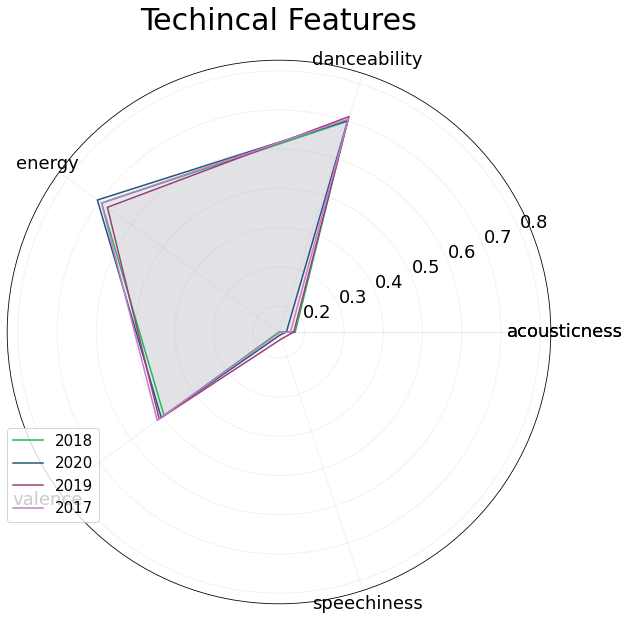

In [8]:
# Q3: On average how many tracks from italian artists are present in Top 100 Italy for each year?

# connect to the DB
driver = GraphDatabase.driver(params.uri, auth=(params.user, params.dbpsw))
# create a session
session = driver.session()

result = session.run("""
    MATCH (c1:Country{id:"IT"})<-[:hasNationality]-(p:Person)-[:isMemberOf]->(a:Artist)-[:partecipateIn]->(t:Track)-[:isPositionedIn]->(ch:Chart)-[:isReferredTo]->(c2:Country{id:"IT"})
    RETURN ch.date.year as year, AVG(t.acousticness) AS avgAcousticness, AVG(t.danceability) AS avgDanceability, AVG(t.energy) AS avgEnergy, 
    AVG(t.valence) AS avgValence, AVG(t.speechiness) AS avgSpeechiness
""")

# Define lists to contain the results
years = []
technicalFeaturesByYear = []

for r in result:
    returnedData = r.values()
    years.append(returnedData[0])
    
    # Retrieve techincal features
    technicalFeaturesByYear.append([returnedData[1],returnedData[2],returnedData[3],returnedData[4],returnedData[5]])

# Print the results
for i in range(0,len(years)):
    print("Year: {}".format(years[i]))
    print("techinalFeatures: {}".format(technicalFeaturesByYear[i]))
    print("")


plotResults(
    title="Techincal Features",
    yArr=technicalFeaturesByYear,
    xTicks=["acousticness","danceability","energy","valence","speechiness"],
    legend=years,
    style="polar",
    showGrid=True,
    fillPlot=True,
    legendLocation=[0, 0.15],
    figSize=(10, 10),
)


session.close()
driver.close()

Year: 2018
techinalFeatures: [0.32542792328315084, 0.6989853578057337, 0.6931524025572274, 0.572282944937101, 0.13399967003505897, 0.17532409156527118, 0.00033971202515982723, 0.15938473912146847, 0.4963640131985969]

Year: 2020
techinalFeatures: [0.5457875457875458, 0.7014070243482002, 0.7065494505494508, 0.5156216332686908, 0.1422100840336131, 0.15286473820297378, 0.00011377268476621404, 0.1562302090066795, 0.505113466925233]

Year: 2019
techinalFeatures: [0.48810754912099197, 0.7116032402619786, 0.6749672526714904, 0.5215442950706644, 0.15286297828335038, 0.17184566528783168, 0.00011035635125818705, 0.17457440537745578, 0.5115909341606338]

Year: 2017
techinalFeatures: [0.30117736422332, 0.7046209646790724, 0.6936555260159518, 0.5928598556779342, 0.1361886061526782, 0.1634150383592857, 0.0002237316938853021, 0.1485389669578431, 0.5177786935055074]



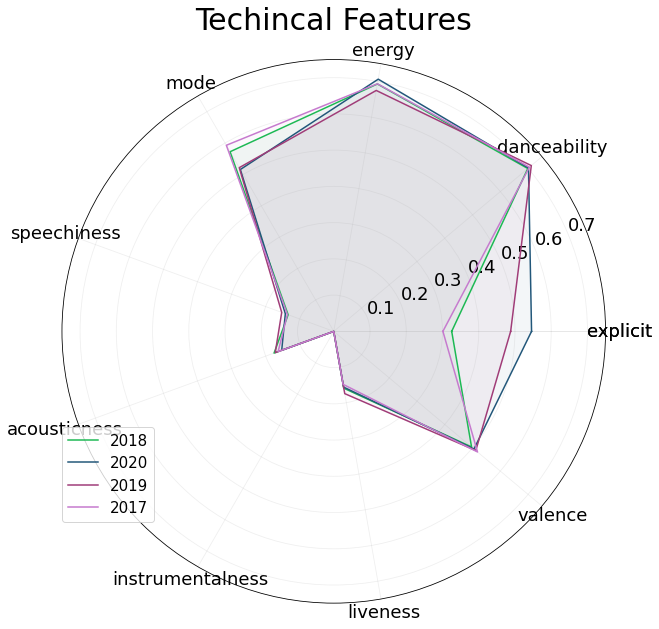

In [9]:
# Q3: On average how many tracks from italian artists are present in Top 100 Italy for each year?

# connect to the DB
driver = GraphDatabase.driver(params.uri, auth=(params.user, params.dbpsw))
# create a session
session = driver.session()

result = session.run("""
    MATCH (c1:Country{id:"IT"})<-[:hasNationality]-(p:Person)-[:isMemberOf]->(a:Artist)-[:partecipateIn]->(t:Track)-[:isPositionedIn]->(ch:Chart)-[:isReferredTo]->(c2:Country{id:"IT"})
    RETURN ch.date.year as year, 
    AVG(toInteger(t.explicit)), 
    AVG(t.danceability), 
    AVG(t.energy), 
    AVG(t.mode), 
    AVG(t.speechiness), 
    AVG(t.acousticness), 
    AVG(t.instrumentalness), 
    AVG(t.liveness), 
    AVG(t.valence) 
""")

# Define lists to contain the results
years = []
technicalFeaturesByYear = []

for r in result:
    returnedData = r.values()
    years.append(returnedData[0])
    
    # Retrieve techincal features
    technicalFeaturesByYear.append([returnedData[1],
    returnedData[2],
    returnedData[3],
    returnedData[4],
    returnedData[5],
    returnedData[6],
    returnedData[7],
    returnedData[8],
    returnedData[9]
    ])

# Print the results
for i in range(0,len(years)):
    print("Year: {}".format(years[i]))
    print("techinalFeatures: {}".format(technicalFeaturesByYear[i]))
    print("")


plotResults(
    title="Techincal Features",
    yArr=technicalFeaturesByYear,
    xTicks=["explicit","danceability","energy","mode","speechiness","acousticness","instrumentalness","liveness","valence"],
    legend=years,
    yLim = [0, 0.75],
    style="polar",
    showGrid=True,
    fillPlot=True,
    legendLocation=[0, 0.15],
    figSize=(10, 10),
)


session.close()
driver.close()

techinalFeatures: [0.3679687941658665, 0.7060446887896454, 0.6889634801288917, 0.535445757250266, 0.12277818418226075, 0.1773977920176369, 0.0028371934586466103, 0.16311499236813906, 0.5176421900616157]

techinalFeatures: [0.6144377910844988, 0.7211710518357248, 0.6145232867598148, 0.5591544184358515, 0.14324321659710806, 0.2043853598258027, 0.006465056186717435, 0.16679498578600327, 0.46534039799189414]



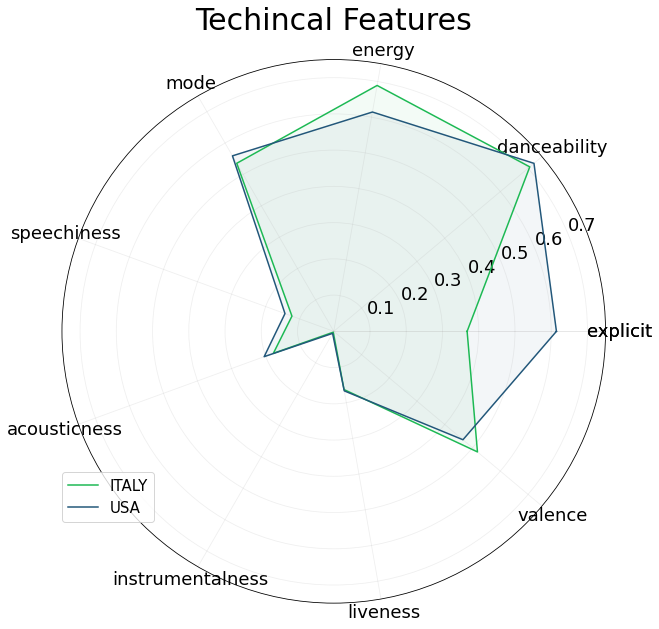

In [10]:
# Q3: On average how many tracks from italian artists are present in Top 100 Italy for each year?

# connect to the DB
driver = GraphDatabase.driver(params.uri, auth=(params.user, params.dbpsw))
# create a session
session = driver.session()

# Define lists to contain the results
technicalFeatures = []

# ITALY
result = session.run("""
    MATCH (c1:Country)<-[:hasNationality]-(p:Person)-[:isMemberOf]->(a:Artist)-[:partecipateIn]->(t:Track)-[:isPositionedIn]->(ch:Chart)-[:isReferredTo]->(c2:Country{id:"IT"})
    RETURN AVG(toInteger(t.explicit)), 
    AVG(t.danceability), 
    AVG(t.energy), 
    AVG(t.mode), 
    AVG(t.speechiness), 
    AVG(t.acousticness), 
    AVG(t.instrumentalness), 
    AVG(t.liveness), 
    AVG(t.valence) 
""")

for r in result:
    returnedData = r.values()
    
    # Retrieve techincal features
    technicalFeatures.append([returnedData[0],
    returnedData[1],
    returnedData[2],
    returnedData[3],
    returnedData[4],
    returnedData[5],
    returnedData[6],
    returnedData[7],
    returnedData[8]
    ])

print("techinalFeatures: {}".format(technicalFeatures[0]))
print("")

# OUTSIDE ITALY
# ITALY

result = session.run("""
    MATCH (c1:Country)<-[:hasNationality]-(p:Person)-[:isMemberOf]->(a:Artist)-[:partecipateIn]->(t:Track)-[:isPositionedIn]->(ch:Chart)-[:isReferredTo]->(c2:Country)
    WHERE c2.id ="US"
    RETURN AVG(toInteger(t.explicit)), 
    AVG(t.danceability), 
    AVG(t.energy), 
    AVG(t.mode), 
    AVG(t.speechiness), 
    AVG(t.acousticness), 
    AVG(t.instrumentalness), 
    AVG(t.liveness), 
    AVG(t.valence) 
""")

for r in result:
    returnedData = r.values()
    # Retrieve techincal features
    technicalFeatures.append([returnedData[0],
    returnedData[1],
    returnedData[2],
    returnedData[3],
    returnedData[4],
    returnedData[5],
    returnedData[6],
    returnedData[7],
    returnedData[8]
    ])

print("techinalFeatures: {}".format(technicalFeatures[1]))
print("")

plotResults(
    title="Techincal Features",
    yArr=technicalFeatures,
    xTicks=["explicit","danceability","energy","mode","speechiness","acousticness","instrumentalness","liveness","valence"],
    legend=["ITALY","USA"],
    yLim = [0, 0.75],
    style="polar",
    showGrid=True,
    fillPlot=True,
    legendLocation=[0, 0.15],
    figSize=(10, 10),
)


session.close()
driver.close()

techinalFeatures: [0.4124457308248913, 0.714751085383501, 0.6955824891461649, 0.5492040520984085, 0.12101823444283656, 0.15214732272069442, 4.1112879884225825e-05, 0.16012026049204048, 0.5499893632416784]

techinalFeatures: [0.4623786407766991, 0.7050849514563102, 0.6787924757281554, 0.5631067961165044, 0.1588701456310681, 0.17777250242718404, 0.0001760131310679611, 0.17588483009708764, 0.49513689320388354]



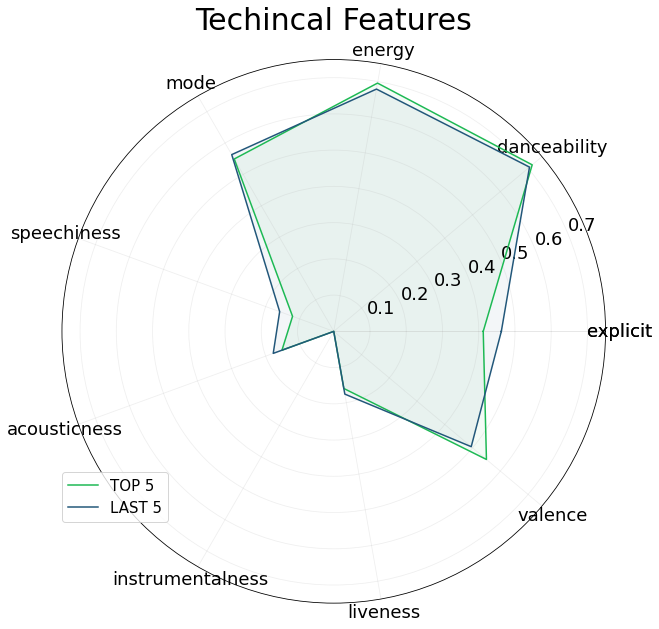

In [11]:
# Q3: On average how many tracks from italian artists are present in Top 100 Italy for each year?

# connect to the DB
driver = GraphDatabase.driver(params.uri, auth=(params.user, params.dbpsw))
# create a session
session = driver.session()

# Define lists to contain the results
technicalFeatures = []

# TOP 5
result = session.run("""
    MATCH (c1:Country{id:"IT"})<-[:hasNationality]-(p:Person)-[:isMemberOf]->(a:Artist)-[:partecipateIn]->(t:Track)-[r:isPositionedIn]->(ch:Chart)-[:isReferredTo]->(c2:Country{id:"IT"})
    WHERE r.position <=5
    RETURN AVG(toInteger(t.explicit)), 
    AVG(t.danceability), 
    AVG(t.energy), 
    AVG(t.mode), 
    AVG(t.speechiness), 
    AVG(t.acousticness), 
    AVG(t.instrumentalness), 
    AVG(t.liveness), 
    AVG(t.valence) 
""")

for r in result:
    returnedData = r.values()
    
    # Retrieve techincal features
    technicalFeatures.append([returnedData[0],
    returnedData[1],
    returnedData[2],
    returnedData[3],
    returnedData[4],
    returnedData[5],
    returnedData[6],
    returnedData[7],
    returnedData[8]
    ])

print("techinalFeatures: {}".format(technicalFeatures[0]))
print("")

# LAST 5
result = session.run("""
    MATCH (c1:Country{id:"IT"})<-[:hasNationality]-(p:Person)-[:isMemberOf]->(a:Artist)-[:partecipateIn]->(t:Track)-[r:isPositionedIn]->(ch:Chart)-[:isReferredTo]->(c2:Country{id:"IT"})
    WHERE r.position >=95
    RETURN AVG(toInteger(t.explicit)), 
    AVG(t.danceability), 
    AVG(t.energy), 
    AVG(t.mode), 
    AVG(t.speechiness), 
    AVG(t.acousticness), 
    AVG(t.instrumentalness), 
    AVG(t.liveness), 
    AVG(t.valence) 
""")

for r in result:
    returnedData = r.values()
    # Retrieve techincal features
    technicalFeatures.append([returnedData[0],
    returnedData[1],
    returnedData[2],
    returnedData[3],
    returnedData[4],
    returnedData[5],
    returnedData[6],
    returnedData[7],
    returnedData[8]
    ])

print("techinalFeatures: {}".format(technicalFeatures[1]))
print("")

plotResults(
    title="Techincal Features",
    yArr=technicalFeatures,
    xTicks=["explicit","danceability","energy","mode","speechiness","acousticness","instrumentalness","liveness","valence"],
    legend=["TOP 5","LAST 5"],
    yLim = [0, 0.75],
    style="polar",
    showGrid=True,
    fillPlot=True,
    legendLocation=[0, 0.15],
    figSize=(10, 10),
)


session.close()
driver.close()

#### Q3: On average how many tracks from Italian artists are present in Top 100 Italy for each year? (Grafico a barre)

Year: 2017
avgNumItalianTracks: 31

Year: 2018
avgNumItalianTracks: 59

Year: 2019
avgNumItalianTracks: 66

Year: 2020
avgNumItalianTracks: 61



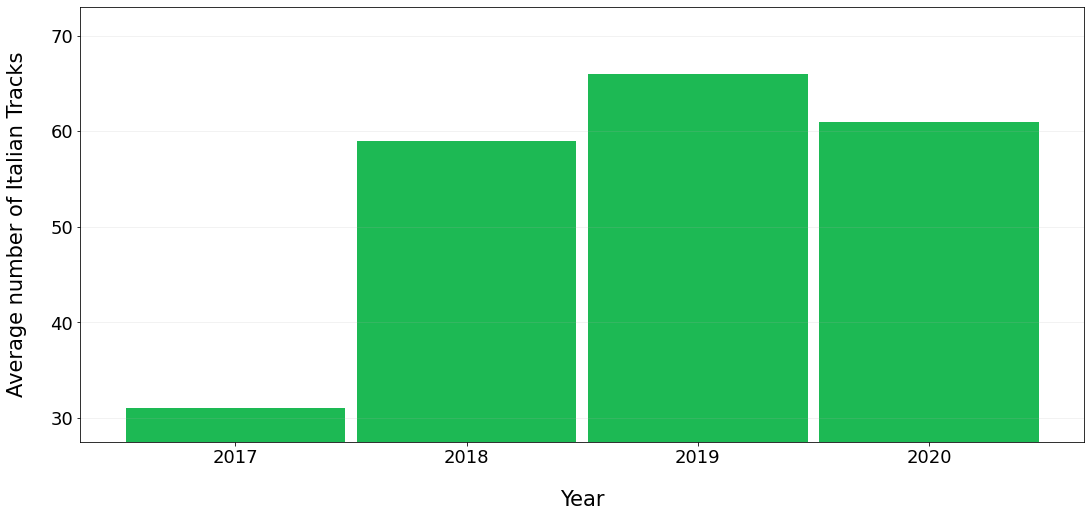

In [12]:
# Q3: On average how many tracks from italian artists are present in Top 100 Italy for each year?

# connect to the DB
driver = GraphDatabase.driver(params.uri, auth=(params.user, params.dbpsw))
# create a session
session = driver.session()

result = session.run("""
    MATCH (c1:Country{id:"IT"})<-[:hasNationality]-(p:Person)-[:isMemberOf]->(a:Artist)-[:partecipateIn]->(t:Track)-[:isPositionedIn]->(ch:Chart)-[:isReferredTo]->(c2:Country{id:"IT"})
    WITH ch,ch.date.year AS year, COUNT(DISTINCT t) as numTracks
    RETURN year,avg(numTracks)
    ORDER BY year
""")

# Define lists to contain the results
years = []
avgNumItalianTracks = []
for r in result:
    returnedData = r.values()
    years.append(returnedData[0])
    avgNumItalianTracks.append(int(returnedData[1]))

# Print the results
for i in range(0,len(years)):
    print("Year: {}".format(years[i]))
    print("avgNumItalianTracks: {:d}".format(avgNumItalianTracks[i]))
    print("")


plotResults(
    x=np.arange(len(years)),
    yArr=[avgNumItalianTracks],
    yLabel="Average number of Italian Tracks",
    xLabel="Year",
    xTicks=years,
    showGrid=True,
    gridAxis="y",
    style="bar",
    saveTitle="query3"
)

session.close()
driver.close()

As we can notice, in 2017 there were only 31 tracks on average in the TOP 100 Italy. We want to discovery if this is just a case of is there any reason behind this result.

So, in the next query we will check how many tracks were released by italian artist for each year.

#### Q4: How many tracks were released from Italian artist every year from 2017 to 2020 ?

Year: 2017
numItalianTracksReleased: 163

Year: 2018
numItalianTracksReleased: 307

Year: 2019
numItalianTracksReleased: 317

Year: 2020
numItalianTracksReleased: 303



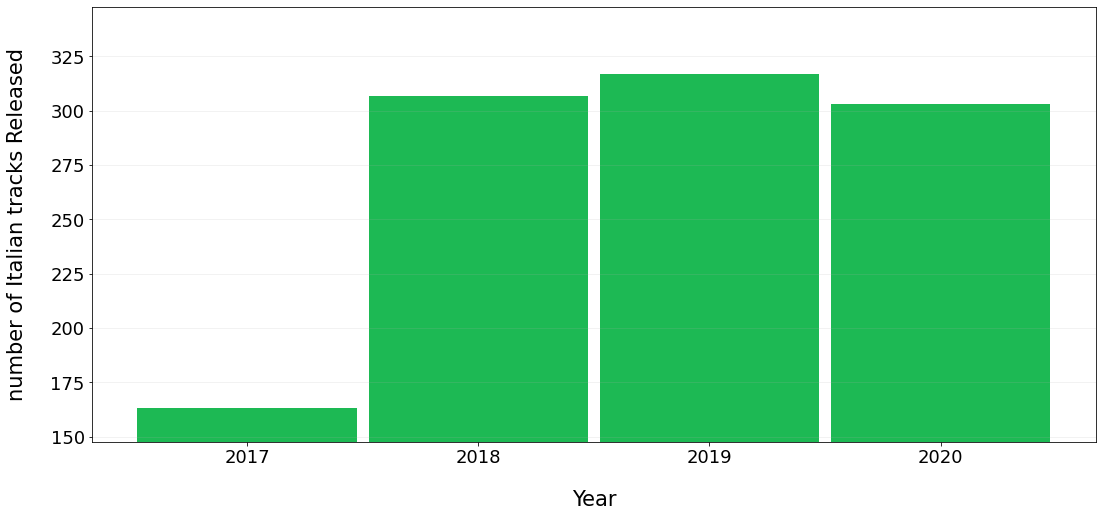

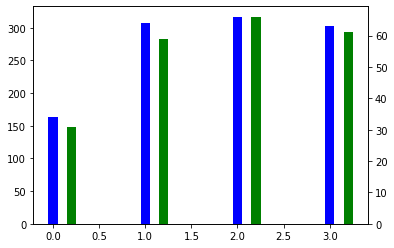

In [60]:
# Q4: How many tracks were released from Italian artist every year from 2017 to 2020 ?

# connect to the DB
driver = GraphDatabase.driver(params.uri, auth=(params.user, params.dbpsw))
# create a session
session = driver.session()

result = session.run("""
    MATCH (c1:Country{id:"IT"})<-[:hasNationality]-(p:Person)-[:isMemberOf]->(a:Artist)-[:partecipateIn]->(t:Track)-[:isPartOf]->(alb:Album)
    WHERE alb.releaseDate.year >= 2017
    WITH alb.releaseDate.year AS year, COUNT(DISTINCT t) as numTracks
    RETURN year,numTracks
    ORDER BY year
""")

# Define lists to contain the results
years = []
numItalianTracksReleased = []
for r in result:
    returnedData = r.values()
    years.append(returnedData[0])
    numItalianTracksReleased.append(returnedData[1])

# Print the results
for i in range(0,len(years)):
    print("Year: {}".format(years[i]))
    print("numItalianTracksReleased: {:d}".format(numItalianTracksReleased[i]))
    print("")


plotResults(
    x=np.arange(len(years)),
    yArr=[numItalianTracksReleased],
    yLabel="number of Italian tracks Released",
    xLabel="Year",
    xTicks=years,
    showGrid=True,
    gridAxis="y",
    style="bar",
    saveTitle="query4"
)




width = 0.1
x = np.arange(len(years))
plt.bar(x,numItalianTracksReleased,color = 'Blue',width=width)
plt.twinx()
plt.bar(x+width*2,avgNumItalianTracks,color = 'Green', width=width)
#show plot
plt.show()


session.close()
driver.close()

Since in 2017 Italian artists relased only 163 tracks (almost half of 2018,2019 and 2020), it is understandable why in 2017 there were only 31 tracks on average in the TOP 100 Italy.

#### Q5: How many different Italian artist entered at least once in Top 100 Italy for each Year ? (Grafico a barre)

Year: 2017
numItalianArtists: 75

Year: 2018
numItalianArtists: 99

Year: 2019
numItalianArtists: 112

Year: 2020
numItalianArtists: 125



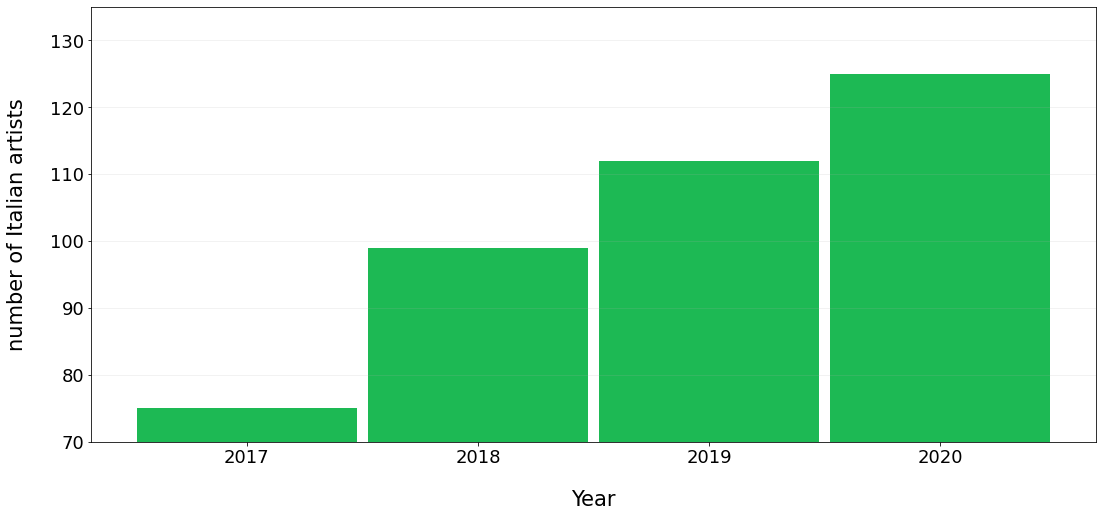

In [14]:
# Q5: How many different Italian artist entered at least once in Top 100 Italy for each Year ?

# connect to the DB
driver = GraphDatabase.driver(params.uri, auth=(params.user, params.dbpsw))
# create a session
session = driver.session()

result = session.run("""
    MATCH (c1:Country{id:"IT"})<-[:hasNationality]-(p:Person)-[:isMemberOf]->(a:Artist)-[:partecipateIn]->(t:Track)-[:isPositionedIn]->(ch:Chart)-[:isReferredTo]->(c2:Country{id:"IT"})
    WITH ch.date.year AS year, COUNT(DISTINCT a) as numArtists,
    RETURN year,numArtists
    ORDER BY year
""")

# Define lists to contain the results
years = []
numItalianArtists = []
for r in result:
    returnedData = r.values()
    years.append(returnedData[0])
    numItalianArtists.append(int(returnedData[1]))

# Print the results
for i in range(0,len(years)):
    print("Year: {}".format(years[i]))
    print("numItalianArtists: {:d}".format(numItalianArtists[i]))
    print("")


plotResults(
    x=np.arange(len(years)),
    yArr=[numItalianArtists],
    yLabel="number of Italian artists",
    xLabel="Year",
    xTicks=years,
    showGrid=True,
    gridAxis="y",
    style="bar",
    saveTitle="query5"
)

session.close()
driver.close()


Now, since we have both the ***number of Italian Tracks*** and the ***number of Italian Artists*** for each year, we can compute a ratio: 
$$(numItalianTracks)/(numItalianArtists)$$
to see on average how many tracks there are for each artist present in the TOP 100 Italy

In [15]:
for i in range(0,len(years)):
    print("Year: {}".format(years[i]))
    print("Ratio: {:.2f}".format(numItalianTracksReleased[i]/numItalianArtists[i]))
    print("")

Year: 2017
Ratio: 1.25

Year: 2018
Ratio: 1.28

Year: 2019
Ratio: 1.36

Year: 2020
Ratio: 1.20



It is possible to notice that even if in 2017 there were less Italian tracks and artists, the ratio is not so different from 2020.

#### Q6: On average how many tracks from Italian artists are present in Top 100 Italy through the different months of the year ? (Grafico a linea)

Year: Jan
avgNumItalianTracksByMonth: 46

Year: Feb
avgNumItalianTracksByMonth: 52

Year: Mar
avgNumItalianTracksByMonth: 51

Year: Apr
avgNumItalianTracksByMonth: 47

Year: May
avgNumItalianTracksByMonth: 52

Year: Jun
avgNumItalianTracksByMonth: 54

Year: Jul
avgNumItalianTracksByMonth: 56

Year: Aug
avgNumItalianTracksByMonth: 54

Year: Sep
avgNumItalianTracksByMonth: 57

Year: Oct
avgNumItalianTracksByMonth: 59

Year: Nov
avgNumItalianTracksByMonth: 61

Year: Dec
avgNumItalianTracksByMonth: 58



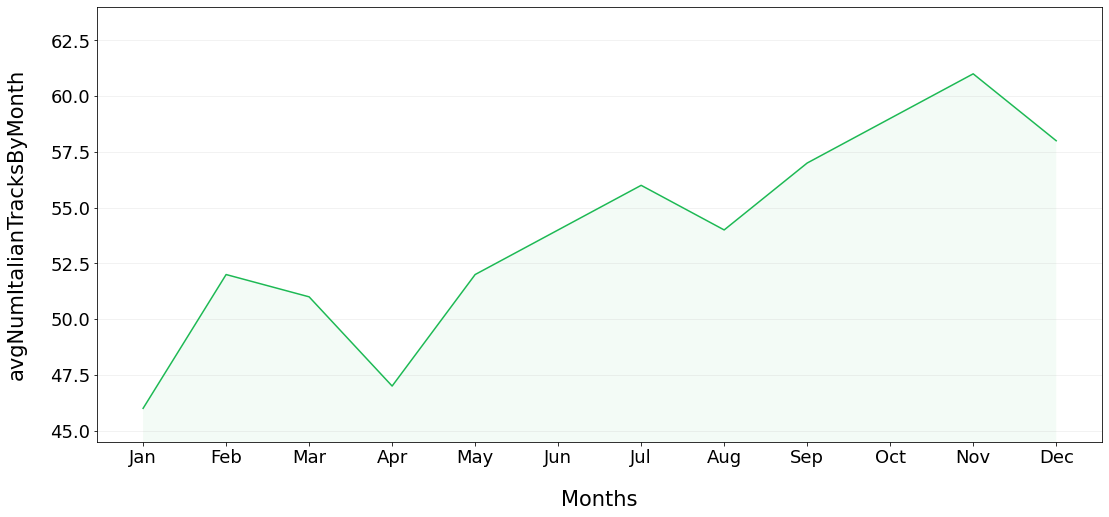

In [16]:
# Q6: On average how many tracks from Italian artists are present in Top 100 Italy through the different months of the year ? 

# connect to the DB
driver = GraphDatabase.driver(params.uri, auth=(params.user, params.dbpsw))
# create a session
session = driver.session()

result = session.run("""
    MATCH (c1:Country{id:"IT"})<-[:hasNationality]-(p:Person)-[:isMemberOf]->(a:Artist)-[:partecipateIn]->(t:Track)-[:isPositionedIn]->(ch:Chart)-[:isReferredTo]->(c2:Country{id:"IT"})
    WITH ch,ch.date.month AS month, COUNT(DISTINCT t) as numTracks
    RETURN month,avg(numTracks)
    ORDER BY month
""")

# Define lists to contain the results
months = []
avgNumItalianTracksByMonth = []
for r in result:
    returnedData = r.values()
    months.append(calendar.month_abbr[returnedData[0]])
    avgNumItalianTracksByMonth.append(int(returnedData[1]))

# Print the results
for i in range(0,len(months)):
    print("Year: {}".format(months[i]))
    print("avgNumItalianTracksByMonth: {:d}".format(avgNumItalianTracksByMonth[i]))
    print("")


plotResults(
    x=np.arange(len(months)),
    yArr=[avgNumItalianTracksByMonth],
    yLabel="avgNumItalianTracksByMonth",
    xLabel="Months",
    xTicks=months,
    showGrid=True,
    gridAxis="y",
    style="line",
    fillPlot=True,
    saveTitle="query6"
)

session.close()
driver.close()


#### Q7: How many albums from Italian artists are released through the different months of the year ? (Grafico a linea)

Year: Jan
numItalianAlbumsReleasedByMonth: 47

Year: Feb
numItalianAlbumsReleasedByMonth: 74

Year: Mar
numItalianAlbumsReleasedByMonth: 39

Year: Apr
numItalianAlbumsReleasedByMonth: 34

Year: May
numItalianAlbumsReleasedByMonth: 62

Year: Jun
numItalianAlbumsReleasedByMonth: 60

Year: Jul
numItalianAlbumsReleasedByMonth: 24

Year: Aug
numItalianAlbumsReleasedByMonth: 13

Year: Sep
numItalianAlbumsReleasedByMonth: 37

Year: Oct
numItalianAlbumsReleasedByMonth: 48

Year: Nov
numItalianAlbumsReleasedByMonth: 44

Year: Dec
numItalianAlbumsReleasedByMonth: 26



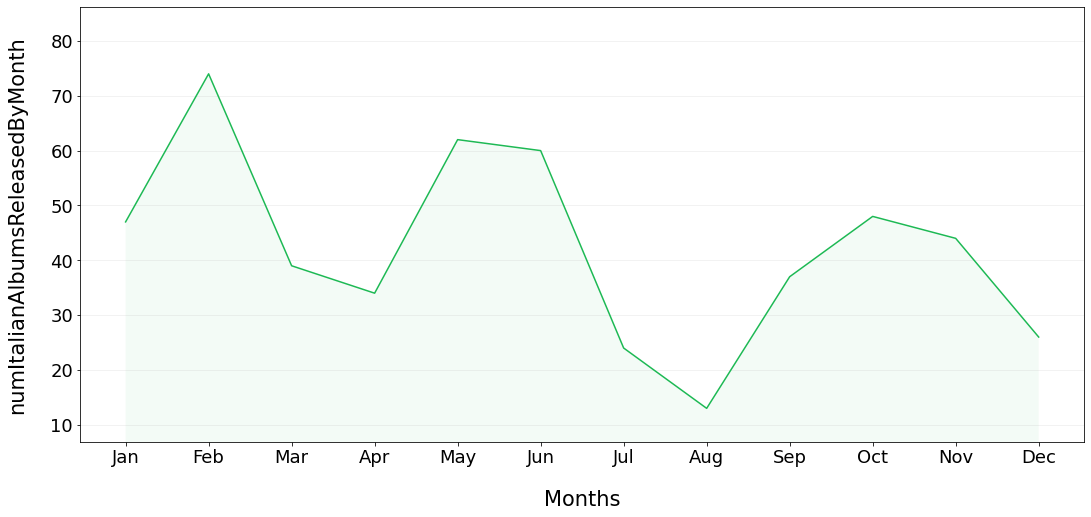

In [17]:
#Q7: How many albums from Italian artists are released through the different months of the year ? 

# connect to the DB
driver = GraphDatabase.driver(params.uri, auth=(params.user, params.dbpsw))
# create a session
session = driver.session()

result = session.run("""
    MATCH (c1:Country{id:"IT"})<-[:hasNationality]-(p:Person)-[:isMemberOf]->(a:Artist)-[:partecipateIn]->(alb:Album)
    WITH alb.releaseDate.month AS month, COUNT(DISTINCT alb) as numAlbums
    RETURN month,numAlbums
    ORDER BY month
""")

# Define lists to contain the results
months = []
numItalianAlbumsReleasedByMonth = []
for r in result:
    returnedData = r.values()
    months.append(calendar.month_abbr[returnedData[0]])
    numItalianAlbumsReleasedByMonth.append(int(returnedData[1]))

# Print the results
for i in range(0,len(months)):
    print("Year: {}".format(months[i]))
    print("numItalianAlbumsReleasedByMonth: {:d}".format(numItalianAlbumsReleasedByMonth[i]))
    print("")


plotResults(
    x=np.arange(len(months)),
    yArr=[numItalianAlbumsReleasedByMonth],
    yLabel="numItalianAlbumsReleasedByMonth",
    xLabel="Months",
    xTicks=months,
    showGrid=True,
    gridAxis="y",
    style="line",
    fillPlot=True,
    saveTitle="query7"
)

session.close()
driver.close()

#### Q7: Who is the Italian artist with the highest number of tracks present in Top 100 Italy for each year? (Nomi degli artisti)

In [18]:
# Q7: Who is the Italian artist with the highest number of tracks present in Top 100 Italy for each year?

# connect to the DB
driver = GraphDatabase.driver(params.uri, auth=(params.user, params.dbpsw))
# create a session
session = driver.session()

result = session.run("""
    MATCH (c1:Country{id:"IT"})<-[:hasNationality]-(p:Person)-[:isMemberOf]->(a:Artist)-[:partecipateIn]->(t:Track)-[:isPositionedIn]->(ch:Chart)-[:isReferredTo]->(c2:Country{id:"IT"})
    WITH a,ch.date.year AS year, COUNT(DISTINCT t) as numTracks
    ORDER BY numTracks DESC
    WITH year,COLLECT(a) AS artists, COLLECT(numTracks) as orderedNumTracks
    RETURN DISTINCT year,artists[0],orderedNumTracks[0]
    ORDER BY year
""")

# Define lists to contain the results
years = []
topArtistsByYear = []
numTracks = []
for r in result:
    returnedData = r.values()
    years.append(returnedData[0])
    topArtistsByYear.append(returnedData[1]["name"])
    numTracks.append(returnedData[2])

# Print the results
for i in range(0,len(years)):
    print("Year: {}".format(years[i]))
    print("Artist: {}".format(topArtistsByYear[i]))
    print("numTracks: {}".format(numTracks[i]))
    print("")

session.close()
driver.close()


Year: 2017
Artist: Guè
numTracks: 20

Year: 2018
Artist: Gemitaiz
numTracks: 28

Year: 2019
Artist: MadMan
numTracks: 30

Year: 2020
Artist: tha Supreme
numTracks: 35



#### Q8: Show the most common position in the TOP 100 Italy obtained by the just retrieved artist.

Artist: Guè
positions: [73, 9, 42, 84, 54, 37, 69, 81, 11, 83, 64, 53, 32, 90, 60, 93, 48, 60, 30, 89, 5, 56, 43, 88, 55, 76, 99, 76, 74, 65, 25, 48, 41, 21, 2, 70, 44, 40, 86, 98, 79, 51, 11, 34, 59, 81, 50, 41, 85, 73, 16, 8, 93, 58, 26, 70, 91, 64, 27, 89, 30, 88, 64, 5, 76, 32, 57, 87, 53, 90, 100, 80, 27, 84, 53, 45, 58, 82, 36, 71, 9, 76, 90, 93, 62, 32, 12, 72, 38, 78, 92, 49, 11, 32, 8, 86, 72, 63, 39, 93, 36, 11, 87, 69, 95, 86, 85, 8, 50, 52, 75, 71, 40, 73, 96, 42, 29, 97, 53, 29, 84, 13, 35, 19, 15, 14, 48, 4, 32, 44, 1, 50, 36, 6, 79, 70, 47, 17, 95, 83, 93, 78, 24, 53, 12, 64, 6, 84, 93, 39, 79, 35, 99, 69, 7, 70, 21, 78, 48, 43, 53, 83]

Artist: Gemitaiz
positions: [71, 12, 86, 6, 84, 27, 76, 56, 48, 26, 95, 8, 29, 39, 37, 14, 12, 21, 26, 16, 10, 2, 33, 21, 72, 37, 66, 80, 50, 18, 88, 70, 38, 55, 62, 91, 4, 72, 80, 29, 100, 93, 88, 76, 12, 60, 46, 37, 99, 88, 56, 73, 6, 19, 76, 7, 77, 72, 17, 65, 86, 75, 74, 13, 69, 4, 71, 29, 72, 68, 78, 14, 65, 70, 84, 54, 73, 71, 53, 

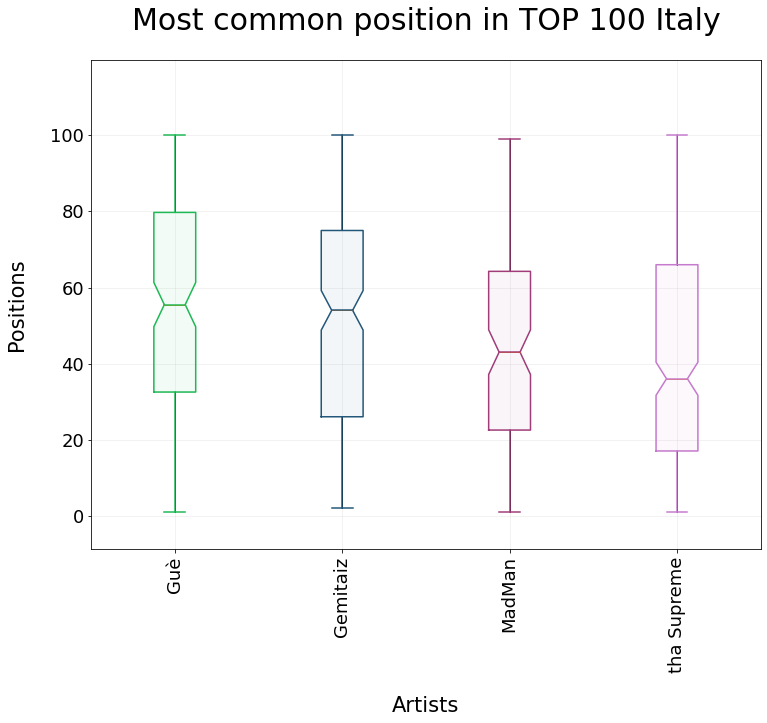

In [67]:
# Q9: Show the top 3 Italian artists with the highest number of tracks present in Top 100 Italy at the same time.

# connect to the DB
driver = GraphDatabase.driver(params.uri, auth=(params.user, params.dbpsw))
# create a session
session = driver.session()

# Define lists to contain the results
positions = []

for i in range(0,len(topArtistsByYear)):
    result = session.run("""
        MATCH (a:Artist {name:$name})-[:partecipateIn]->(t:Track)-[r:isPositionedIn]->(ch:Chart)-[:isReferredTo]->(c2:Country{id:"IT"})
        WHERE ch.date >= date({year: $year, month: 1, day: 1}) AND ch.date <= date({year: $year, month: 12, day: 31})
        RETURN a,COLLECT(r.position) AS positions
    """,name=topArtistsByYear[i],year=years[i])

    for r in result:
        returnedData = r.values()
        positions.append(returnedData[1])

# Print the results
for i in range(0,len(topArtistsByYear)):
    print("Artist: {}".format(topArtistsByYear[i]))
    print("positions: {}".format(positions[i]))
    print("")


plotResults(
    title="Most common position in TOP 100 Italy",
    yArr=positions,
    style="boxplot",
    fillPlot=True,
    figSize=(12, 9),
    xLabel="Artists",
    yLabel="Positions",
    showGrid=True,
    xTicksPosition=range(0, 4),
    xTicks=topArtistsByYear,
    xTicksRotation=90
)

session.close()
driver.close()



####  Q9: Show the top 3 Italian artists with the highest number of tracks present in Top 100 Italy at the same time.

In [20]:
# Q9: Show the top 3 Italian artists with the highest number of tracks present in Top 100 Italy at the same time.

# connect to the DB
driver = GraphDatabase.driver(params.uri, auth=(params.user, params.dbpsw))
# create a session
session = driver.session()

result = session.run("""
    MATCH (c1:Country{id:"IT"})<-[:hasNationality]-(p:Person)-[:isMemberOf]->(a:Artist)-[:partecipateIn]->(t:Track)-[:isPositionedIn]->(ch:Chart)-[:isReferredTo]->(c2:Country{id:"IT"})
    WITH a,ch, COUNT(DISTINCT t) as numTracks
    ORDER BY numTracks DESC
    WITH a,COLLECT(ch) AS charts, COLLECT(numTracks) as orderedNumTracks
    RETURN DISTINCT a,charts[0],orderedNumTracks[0]
    LIMIT 3
""")

for r in result:
    returnedData = r.values()
    print("Artist: {}".format(returnedData[0]["name"]))
    print("Chart: {}".format(returnedData[1]["id"]))
    print("numTracks: {}".format(returnedData[2]))
    print("")
session.close()
driver.close()


Artist: tha Supreme
Chart: top-100-IT-2019-11-17
numTracks: 24

Artist: Marracash
Chart: top-100-IT-2019-11-17
numTracks: 19

Artist: Ultimo
Chart: top-100-IT-2019-04-07
numTracks: 18



The numbers of tracks present simultaneously in the TOP 100 Italy are quite high (24,19 and 18). 

We want to check if these three artists released an album on the same month of the chart or in the previous one.

In [21]:
topThreeArtists = ["tha Supreme","Marracash","Ultimo"]
years = [2019,2019,2019]
months = [11,11,4]

# connect to the DB
driver = GraphDatabase.driver(params.uri, auth=(params.user, params.dbpsw))
# create a session
session = driver.session()

for i in range(0,len(topThreeArtists)):

    print("SEARCHING FOR AN ALBUM PUBLISHED BY "+topThreeArtists[i])

    result = session.run("""
        MATCH (a:Artist {name:$artist})-[:partecipateIn]->(alb:Album {albumType:"album"})
        WHERE alb.releaseDate >= date({year: $year, month: $month-1, day: 1}) AND alb.releaseDate <= date({year: $year, month: $month, day: 30})
        RETURN a.name, alb.name, alb.releaseDate
        """,artist=topThreeArtists[i],year=years[i],month=months[i])

    for r in result:
        returnedData = r.values()
        print("Alb: {}".format(returnedData[0]))
        print("Album: {}".format(returnedData[1]))
        print("Album relaseDate: {}".format(str(returnedData[2])))
        print("")

session.close()
driver.close()

SEARCHING FOR AN ALBUM PUBLISHED BY tha Supreme
Alb: tha Supreme
Album: 23 6451
Album relaseDate: 2019-11-15

SEARCHING FOR AN ALBUM PUBLISHED BY Marracash
Alb: Marracash
Album: Persona
Album relaseDate: 2019-10-31

SEARCHING FOR AN ALBUM PUBLISHED BY Ultimo
Alb: Ultimo
Album: Colpa Delle Favole
Album relaseDate: 2019-04-05



So, these Italian artists managed to have a lot of tracks in the TOP 100 Italy at the same time, because they released albums whose tracks probably entered all in TOP 100 Italy.

#### Q10: Show the youngest artist who entered in the first 10 positions of Top 100 Italy for each year.

In [22]:
# Q10: Show the youngest artist who entered in the first 10 positions of Top 100 Italy for each year.

# connect to the DB
driver = GraphDatabase.driver(params.uri, auth=(params.user, params.dbpsw))
# create a session
session = driver.session()

result = session.run("""
    MATCH (c1:Country{id:"IT"})<-[:hasNationality]-(p:Person)-[:isMemberOf]->(a:Artist)-[:partecipateIn]->(t:Track)-[r:isPositionedIn]->(ch:Chart)-[:isReferredTo]->(c2:Country{id:"IT"})
    WHERE r.position <=10 AND p.birthDate IS NOT NULL
    WITH ch,a,p
    ORDER BY p.birthDate DESC
    WITH ch.date.year AS year, COLLECT(a.name) AS artistsNames, COLLECT(p.birthDate) AS artistsBirthDates
    RETURN year,artistsNames[0],artistsBirthDates[0]
""")

for r in result:
    returnedData = r.values()
    print("Year: {}".format(returnedData[0]))
    print("Artist: {}".format(returnedData[1]))
    print("BirthDate: {}".format(str(returnedData[2])))
    print("")
session.close()
driver.close()

Year: 2020
Artist: Rondodasosa
BirthDate: 2002-04-29

Year: 2018
Artist: Martina Attili
BirthDate: 2001-07-11

Year: 2019
Artist: tha Supreme
BirthDate: 2001-03-17

Year: 2017
Artist: Måneskin
BirthDate: 2001-01-18



Of course in the case of ***Maneskin*** the birthDate is referred to the youngest member of the group.

### Italian tracks abroad

#### Q11: How many tracks from Italian artist are present in a Top 100 of a different country for each year (grafico barre)

Year: 2017
numItalianTracksAbroad: 15

Year: 2018
numItalianTracksAbroad: 19

Year: 2019
numItalianTracksAbroad: 19

Year: 2020
numItalianTracksAbroad: 27



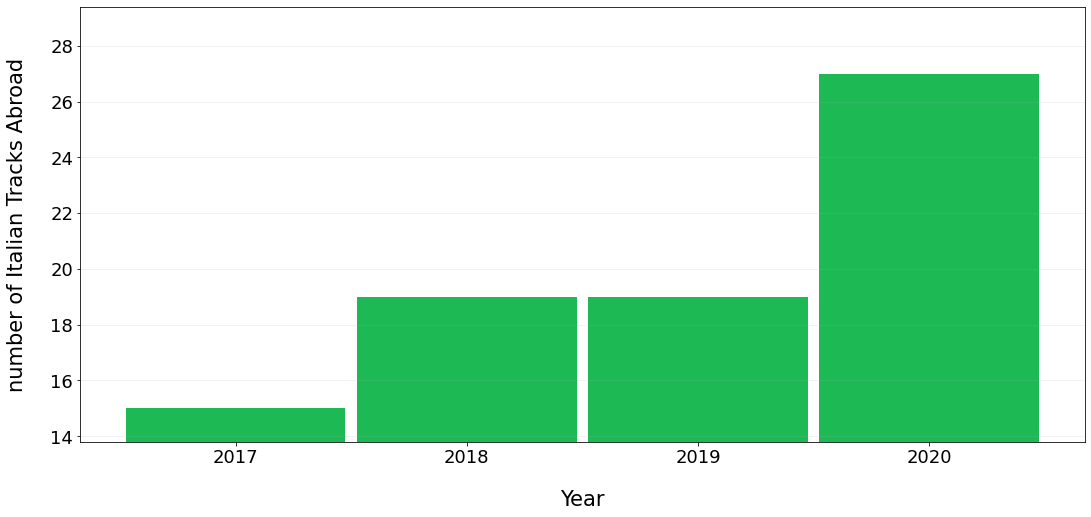

In [23]:
# Q11: How many tracks from Italian artist are present in a Top 100 of a different country for each year

# connect to the DB
driver = GraphDatabase.driver(params.uri, auth=(params.user, params.dbpsw))
# create a session
session = driver.session()

result = session.run("""
    MATCH (c1:Country{id:"IT"})<-[:hasNationality]-(p:Person)-[:isMemberOf]->(a:Artist)-[:partecipateIn]->(t:Track)-[:isPositionedIn]->(ch:Chart)-[:isReferredTo]->(c2:Country)
    WHERE c2.id<>"IT"
    WITH ch.date.year AS year, COUNT(DISTINCT t) AS numItalianTracks
    RETURN year,numItalianTracks
    ORDER BY year
""")

# Define lists to contain the results
years = []
numItalianTracksAbroad = []
for r in result:
    returnedData = r.values()
    years.append(returnedData[0])
    numItalianTracksAbroad.append(int(returnedData[1]))

# Print the results
for i in range(0,len(years)):
    print("Year: {}".format(years[i]))
    print("numItalianTracksAbroad: {:d}".format(numItalianTracksAbroad[i]))
    print("")


plotResults(
    x=np.arange(len(years)),
    yArr=[numItalianTracksAbroad],
    yLabel="number of Italian Tracks Abroad",
    xLabel="Year",
    xTicks=years,
    showGrid=True,
    gridAxis="y",
    style="bar",
    saveTitle="query11"
)
session.close()
driver.close()

#### Q12: Show the countries that listen the most to Italian tracks. (show Names and numbers)

In [24]:
# Q12: Show the top 5 countries that listen the most to Italian tracks.

# connect to the DB
driver = GraphDatabase.driver(params.uri, auth=(params.user, params.dbpsw))
# create a session
session = driver.session()

result = session.run("""
    MATCH (c1:Country{id:"IT"})<-[:hasNationality]-(p:Person)-[:isMemberOf]->(a:Artist)-[:partecipateIn]->(t:Track)-[:isPositionedIn]->(ch:Chart)-[:isReferredTo]->(c2:Country)
    WHERE c2.id<>"IT"
    RETURN c2.name, COUNT(DISTINCT t) AS numItalianTracks
    ORDER BY numItalianTracks DESC
""")

# Define lists to contain the results
countries = []
numItalianTracksByCountry = []
for r in result:
    returnedData = r.values()
    countries.append(returnedData[0])
    numItalianTracksByCountry.append(returnedData[1])

# Print the results
for i in range(0,len(countries)):
    print("Country: {}".format(countries[i]))
    print("numItalianTracksByCountry: {:d}".format(numItalianTracksByCountry[i]))
    print("")

session.close()
driver.close()

Country: Switzerland
numItalianTracksByCountry: 26

Country: Norway
numItalianTracksByCountry: 17

Country: France
numItalianTracksByCountry: 10

Country: Austria
numItalianTracksByCountry: 10

Country: Germany
numItalianTracksByCountry: 10

Country: Belgium
numItalianTracksByCountry: 8

Country: Sweden
numItalianTracksByCountry: 8

Country: Poland
numItalianTracksByCountry: 7

Country: Netherlands
numItalianTracksByCountry: 6

Country: Finland
numItalianTracksByCountry: 6

Country: Spain
numItalianTracksByCountry: 6

Country: Denmark
numItalianTracksByCountry: 5

Country: Virgin Islands, British
numItalianTracksByCountry: 4

Country: United Kingdom of Great Britain and Northern Ireland
numItalianTracksByCountry: 4

Country: Turkey
numItalianTracksByCountry: 4

Country: Canada
numItalianTracksByCountry: 3

Country: Portugal
numItalianTracksByCountry: 3

Country: New Zealand
numItalianTracksByCountry: 2

Country: Malaysia
numItalianTracksByCountry: 2

Country: Australia
numItalianTracks

In [25]:
import plotly.express as px

d = {'countries':countries,'numItalianTracksByCountry':numItalianTracksByCountry}
data = pd.DataFrame(d, columns=['countries','numItalianTracksByCountry'])

fig = px.choropleth(data, 
                    locations="countries",
                    locationmode='country names',
                    color="numItalianTracksByCountry", 
                    hover_name="countries",
                    color_continuous_scale='tealgrn')

fig.show()

#### Q13: Who is the artist present in the highest number of TOP 100 of different countries? Show also the countries in which he/she is present.

In [26]:
# Q13: Who is the artist present in the highest number of different countries? Show also the countries in which he/she is present.

# connect to the DB
driver = GraphDatabase.driver(params.uri, auth=(params.user, params.dbpsw))
# create a session
session = driver.session()

result = session.run("""
    MATCH (c1:Country{id:"IT"})<-[:hasNationality]-(p:Person)-[:isMemberOf]->(a:Artist)-[:partecipateIn]->(t:Track)-[:isPositionedIn]->(ch:Chart)-[:isReferredTo]->(c2:Country)
    WHERE c2.id<>"IT"
    RETURN a, COUNT(DISTINCT c2) AS numCountries, COLLECT(DISTINCT ch.name) AS charts
    ORDER BY numCountries DESC
    LIMIT 1
""")

for r in result:
    returnedData = r.values()
    print("Artist: {}".format(returnedData[0]["name"]))
    print("numCountries: {}".format(returnedData[1]))
    print("Countries: {}".format(returnedData[2]))
    print("")
session.close()
driver.close()

Artist: Gigi D'Agostino
numCountries: 30
Countries: ['TOP 100 Brazil', 'TOP 100 Poland', 'TOP 100 Switzerland', 'TOP 100 Belgium', 'TOP 100 Norway', 'TOP 100 Australia', 'TOP 100 Taiwan', 'TOP 100 Mexico', 'TOP 100 Germany', 'TOP 100 Ireland', 'TOP 100 Singapore', 'TOP 100 Sweden', 'TOP 100 Finland', 'TOP 100 USA', 'TOP 100 Portugal', 'TOP 100 France', 'TOP 100 Austria', 'TOP 100 New Zealand', 'TOP 100 UK', 'TOP 100 Malaysia', 'TOP 100 Netherlands', 'TOP 100 Spain', 'TOP 100 Turkey', 'TOP 100 Canada', 'TOP 100 Philippines', 'TOP 100 Denmark', 'TOP 100 Indonesia', 'TOP 100 Costa Rica', 'TOP 100 Ecuador', 'TOP 100 Colombia']



#### Q14: Who is the artist with the highest number of tracks present oustide Italy ? Show also the names of the tracks. 

In [27]:
# Q14: Who is the artist with the highest number of tracks present oustide Italy ? Show also the names of the tracks. 

# connect to the DB
driver = GraphDatabase.driver(params.uri, auth=(params.user, params.dbpsw))
# create a session
session = driver.session()

result = session.run("""
MATCH (c1:Country{id:"IT"})<-[:hasNationality]-(p:Person)-[:isMemberOf]->(a:Artist)-[:partecipateIn]->(t:Track)-[:isPositionedIn]->(ch:Chart)-[:isReferredTo]->(c2:Country)
WHERE c2.id<>"IT"
RETURN a, COUNT(DISTINCT t) AS numTracks, COLLECT(DISTINCT t.name) as trackNames
ORDER BY numTracks DESC
LIMIT 1
""")

for r in result:
    returnedData = r.values()
    print("Artist: {}".format(returnedData[0]["name"]))
    print("numItalianTracks: {}".format(returnedData[1]))
    print("Tracks: {}".format(returnedData[2]))
    print("")
session.close()
driver.close()

Artist: Sfera Ebbasta
numItalianTracks: 11
Tracks: ['Happy Birthday', 'Uber', 'Rockstar', 'McQueen', 'Serpenti A Sonagli', 'Pablo', 'Bottiglie Privè', 'Cupido (feat. Quavo)', 'Sciroppo (feat. DrefGold)', 'Peace & Love', 'Ricchi x Sempre']



We have shown that actually there are two different criteria to determine the most "widespread" Italian artist abroad:

**1)** Count how many different countries the artist has reached excluding Italy. In this case, the best is ***Gigi D'Agostino***


**2)** Count the total number of tracks present in countries outside Italy. In this case, the best is ***Sfera Ebbasta***